# Binary Classifier

 1. Loading images, changing images from RGB to gray and finally frescaling all images to (68, 102). Creating labels for every image.
 2. Split the data set into training data set and testing data by 8:2 which are 180 and 45 respectively as the scale of whole  data is small, then re-define the labels of images.
 3. creat and train the model. I choose the 10-fold cross validation to train and test the model and the split of the validation data is in this step.
 4. Print the results of training and testing and ROC curve.

### Loading datas

In [17]:
from sklearn.datasets.samples_generator import make_classification
from PIL import Image
import os
import skimage
import numpy as np


# Loading datas
path = "../Phos2_0_2MP/"
label = [] # create a list variance to store the labels
X = np.ndarray([225,68*102]) # it must be ndarray otherwise it will show a ValueError: setting an array element with a sequence.
i = 0
for root, dirs, files in os.walk(path):
    for filenames in files:
#         print(os.path.join(root,filenames))
        if (os.path.splitext(filenames)[1] == ".png"):
            img = skimage.io.imread(os.path.join(root,filenames))
            img_gray = skimage.color.rgb2gray(img)
            img_gray_rescale = skimage.transform.rescale(img_gray, 0.2)
            if ('nonuni' in filenames):
                label.append("non-uniform")
            else:
                label.append("uniform")
            ravel_img = np.ravel(img_gray_rescale)
            X[i] = ravel_img
            i = i+1
y = np.array(label)

/root/anaconda3/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


### Spliting data set

In [22]:
# obtain a random index of datasets
shuffle_index = np.random.permutation(225)

# Split traing and testing data
X_train_data, X_test, y_train_data, y_test = X[shuffle_index[:180],:], X[shuffle_index[180:],:], y[shuffle_index[:180]], y[shuffle_index[180:]]
# print(X_train.shape)

y_train_uni = (y_train_data == 'uniform')  # define training labels
y_test_uni = (y_test == 'uniform')  # define testing labels

### Train model

In [23]:
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

# the model
bin_clf = LogisticRegression(max_iter=10,tol=1e-4, solver='liblinear')  #  how to define the max_iter?  generally, choosing 10. it can also be changed by comparing the accuracy.
bin_clf1 = bin_clf  # validate model
bin_clf.fit(X_train_data, y_train_uni)  # train the model
train_pred = bin_clf.predict(X_train_data)  # predicttion of training data


# k-fold cross validation
kf = KFold(n_splits=10)  # set 10-fold cross validation
k_train_accuracy_sum = 0
validation_accuracy_sum = 0
for X_train_num, X_validation_num in kf.split(X_train_data):
    # training dataset
    X_train = X_train_data[X_train_num]
    
    #  validation dataset
    X_validation = X_train_data[X_validation_num]
    
    # the labels of training dataset
    y_train = y_train_uni[X_train_num]
    
    # the labels of validation dataset
    y_validation = y_train_uni[X_validation_num]
#     bin_clf = LogisticRegression(max_iter=10,tol=1e-5, solver='liblinear')  #  how to define the max_iter?  generally, choosing 10. it can also be changed by comparing the accuracy.
    bin_clf1.fit(X_train, y_train)
    y_pred = bin_clf1.predict(X_train)
    k_train_accuracy_sum += accuracy_score(y_train, y_pred)
    y_validation_pred = bin_clf.predict(X_validation)
    validation_accuracy_sum += accuracy_score(y_validation, y_validation_pred)
    
k_train_accuracy = k_train_accuracy_sum/kf.n_splits
validation_accuracy = validation_accuracy_sum/kf.n_splits
print("k_train_accuracy = {0}".format(k_train_accuracy))
print("validation_accuracy = {0}".format(validation_accuracy))

print("------------------------------")
print("The size of data sets:")
print("Training data size is {}".format(len(X_train)))
print("Validation data size is {}".format(len(X_validation)))
print("Testing data size is {}".format(len(X_test)))

k_train_accuracy = 0.9987654320987656
validation_accuracy = 0.9333333333333333
------------------------------
The size of data sets:
Training data size is 162
Validation data size is 18
Testing data size is 45


### Print the results

Training set:
accuracy = 1.0
precision = 1.0
recall = 1.0
f1 = 1.0
confusion matrix: 
 [[ 71   0]
 [  0 109]])


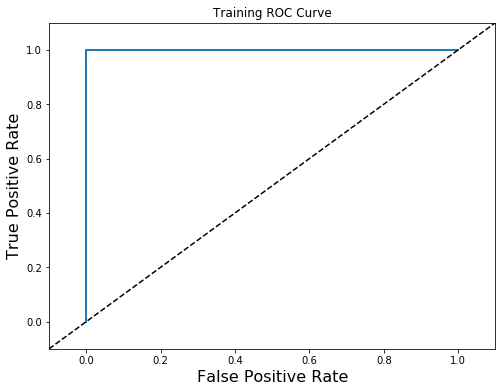

Testing set:
accuracy = 0.9111111111111111
precision = 0.8666666666666667
recall = 1.0
f1 = 0.9285714285714286
confusion matrix: 
 [[15  4]
 [ 0 26]])


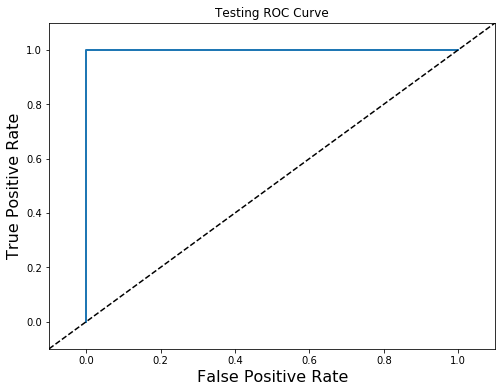

In [24]:
# define a function of printing the results(e.g. precision)
def printResults(label,pred):
    accuracy = accuracy_score(label, pred)
    precision = precision_score(label, pred)
    recall = recall_score(label, pred)
    f1 = f1_score(label, pred)
    confusion_matrix_all = confusion_matrix(label, pred)

    print("accuracy = {0}".format(accuracy))
    print("precision = {0}".format(precision))
    print("recall = {0}".format(recall))
    print("f1 = {0}".format(f1))
    print("confusion matrix: \n {0})".format(confusion_matrix_all))

    
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([-0.1, 1.1], [-0.1, 1.1], 'k--')
    plt.axis([-0.1, 1.1, -0.1, 1.1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
# print training results
print("Training set:")
printResults(y_train_uni, train_pred)
train_scores = bin_clf.decision_function(X_train_data)
fprt,tprt, thresholdst = roc_curve(y_train_uni, train_scores)
plt.figure(figsize=(8, 6))
plt.title('Training ROC Curve',fontsize='large')
plot_roc_curve(fprt, tprt)
plt.savefig("roc_curve_plot_training")
plt.show()

# print test results
test_pred = bin_clf.predict(X_test)  # the prediction of testing data
print("Testing set:")
printResults(y_test_uni, test_pred)
 
    
    
# test_scores = cross_val_predict(bin_clf, X_test, y_test_uni, cv=10,
#                              method="decision_function")
test_scores = bin_clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test_uni, test_scores)
plt.figure(figsize=(8, 6))
plt.title('Testing ROC Curve',fontsize='large')
plot_roc_curve(fpr, tpr)
plt.savefig("roc_curve_plot_test")
plt.show()

### Discussion
1. From the results, it shows there a good performence on testing data which means the generalization of this model is good. From 10-fold cross validation part which is used to detect over fitting problem, we can see the validation data set has 18 images.
2. In spliting data sets, at first I splitted the training data set and testing data set by 9:1. In this situation, the results of testing were not good. For example, the accuracy ranged from 85% to 92%. After changing the scale of these two data set by 8:2, the performance of model is better.
3. I modified the parameters in LogisticRegression as known as the part of creating moedel. I tried four different parameters on "tol"(1e-1, 1e-4, 1e-5, 1e-8). It took much more time on training if tol becomes smaller. The model ("tol=1e-4") has similar performance when it is compared to the model ("tol=1e-5).
4. max_iter has a few influence on model as I tried 10, 20, 100 and there was almost no change on the results.
5. I used the model which was created by k-fold corss validation. This kind of model has worse perfomance on testing data than the one which was not created by k-fold corss validation, although we can see the mean validation accuracy is good in the part the Train model.

#### Quesions
1. The ROC curve had some corners(as the pictures show). Why it happends?

2. What the effect is of the function named "cross_val_predict" ?
   Why it can create a group of prediction data?
   
3. The part of k-fold cross validation will create k different model. Should we choose the best model from this part? If it is true, how can we choose it, by the ROC curve or accuracy? 
4. The model I choosed created by k-fold part is not good as I thought(the picture shows below). why it is worse than the model not created by k-fold part?
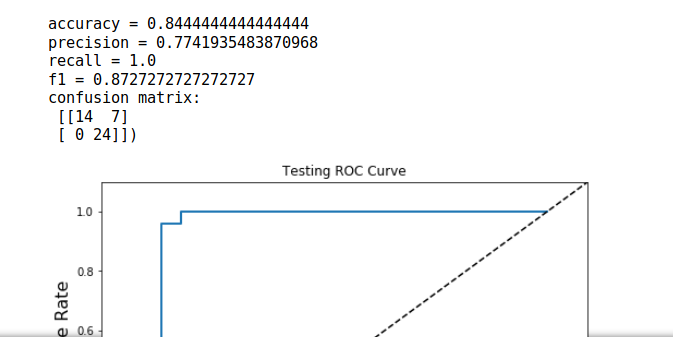
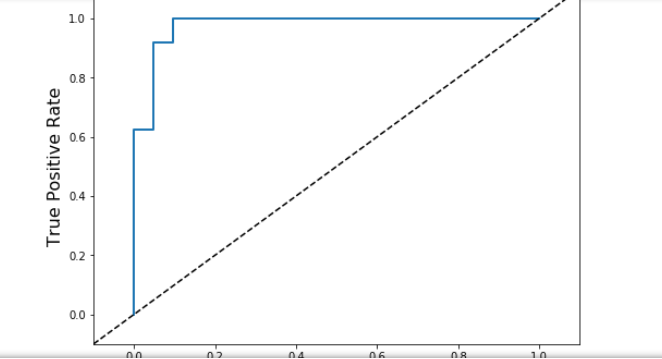
   

# Multiclass classification

1. Loading images, changing images from RGB to gray and finally frescaling all images to (68, 102). Creating labels for every image.
2. Split the data set into training data set and testing data by 8:2 which are 180 and 45 respectively as the scale of whole  data is small, then re-define the labels of images.
3. creat and train the model. I choose OVO classifier.
4. Print the results of training and testing and ROC curve.

### Load images and creat label

In [88]:
from sklearn.datasets.samples_generator import make_classification
from PIL import Image
import os
import skimage
import numpy as np


path = "../Phos2_0_2MP/"

label = []
X = np.ndarray([225,68*102]) # it must be ndarray otherwise it will show a ValueError: setting an array element with a sequence.
i = 0
for root, dirs, files in os.walk(path):
    for filenames in files:
#         print(os.path.join(root,filenames))
        if (os.path.splitext(filenames)[1] == ".png"):
            img = skimage.io.imread(os.path.join(root,filenames))
            img_gray = skimage.color.rgb2gray(img)
            img_gray_rescale = skimage.transform.rescale(img_gray, 0.2)
            if ("minus" in filenames):
                label.append("minus")
            elif ("plus" in filenames):
                label.append("plus")
            else:
                label.append("regular")
            ravel_img = np.ravel(img_gray_rescale)
            X[i] = ravel_img
            i = i+1
y = np.array(label)

/root/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


### Split data sets

In [194]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)
print(len(X_test))
print(y_test)

45
['plus' 'plus' 'plus' 'regular' 'minus' 'minus' 'minus' 'regular' 'plus'
 'minus' 'plus' 'regular' 'plus' 'minus' 'regular' 'regular' 'regular'
 'plus' 'plus' 'plus' 'plus' 'plus' 'minus' 'minus' 'plus' 'regular'
 'regular' 'minus' 'regular' 'plus' 'plus' 'minus' 'minus' 'regular'
 'plus' 'plus' 'regular' 'minus' 'regular' 'plus' 'regular' 'minus'
 'regular' 'minus' 'regular']


### Train data

In [197]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

# sgd_clf = SGDClassifier(max_iter=50, random_state=42)
# sgd_clf.fit(X_train, y_train)
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=50, random_state=52))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=50,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=52, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

### Print results 

In [198]:
from sklearn.model_selection import cross_val_score

# print(cross_val_score(ovo_clf,X_train, y_train, cv=10))
y_train_pred = cross_val_predict(ovo_clf, X_train, y_train, cv=10)
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training data set:")
print("Train_accuracy = {0}".format(train_accuracy))
print('Confusion_matrix_training: \n{0}'.format(conf_matrix_train))

y_test_pred = cross_val_predict(ovo_clf, X_test, y_test, cv=10)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test data set:")
print("Test_accuracy = {0}".format(test_accuracy))
print('Confusion_matrix_testing: \n{0}'.format(conf_matrix_test))

Training data set:
Train_accuracy = 0.7722222222222223
Confusion_matrix_training: 
[[36  5  6]
 [ 1 33  9]
 [ 4 16 70]]
Test data set:
Test_accuracy = 0.7111111111111111
Confusion_matrix_testing: 
[[ 7  2  4]
 [ 0 16  1]
 [ 1  5  9]]


### Discussion

1. In this part, I still split data sets into training data set and testing data set by 8:2 which are 180 images and 45 images respectively as I can get better model in this way.
2. As for the model, I finally choosed the OneVsOne classifier instead of SGD classifier as the former one can get higher accuracy on training and testing than the latter one(0.772 and 0.711 on training respectively).
3. From the results, for example, the accuracy is not good whether during training or testing. On one hand, the scale of data set is not big enough. On the other hand, there are some parameters which have effects on the final results like max_iter. I tried 10 different numbers on this parameter.50 is a relatively suitable number.